In [83]:
from __future__ import print_function
import numpy as np
np.random.seed(1)
import sys
import sklearn
import sklearn.ensemble
%load_ext autoreload
%autoreload 2
from anchor import utils
from anchor import anchor_tabular
from numba import jit
import pickle
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the dataset
This dataset is about predicting if a person makes more or less than 50,000 dollars

In [3]:
# make sure you have adult/adult.data inside dataset_folder
dataset_folder = '.'
dataset = utils.load_dataset('adult', balance=True, dataset_folder=dataset_folder, discretize=True)

Let's train a classifier for this

In [4]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.9350338780390594
Test 0.8489483747609943


### Getting an anchor

Now let's start the explainer. We need the training data to perturb instances.
`categorical_names` is a map from integer to list of strings, containing names for each
            value of the categorical features. Every feature that is not in
            this map will be considered as ordinal or continuous, and thus discretized.


In [5]:
explainer = anchor_tabular.AnchorTabularExplainer(
    dataset.class_names,
    dataset.feature_names,
    dataset.train,
    dataset.categorical_names)

In [31]:
class MyExplenation:
    def __init__(self, index, fit_examples, test_cov, exp):
        self.index = index
        self.fit_examples = fit_examples
        self.test_cov = test_cov
        self.names =  exp.names()
        self.coverage = exp.coverage()
        self.precision = exp.precision()

Below, we get an anchor for prediction number 0. An anchor is a sufficient condition - that is, when the anchor holds, the prediction should be the same as the prediction for this instance.

In [32]:
def get_exp(idx):
    return explainer.explain_instance(dataset.test[idx], c.predict, threshold=0.95)

In [33]:
def get_fit_examples(exp, idx):
    return np.where(np.all(dataset.test[:, exp.features()] == dataset.test[idx][exp.features()], axis=1))[0]

In [34]:
def get_test_cov(fit_anchor):
    return (fit_anchor.shape[0] / float(dataset.test.shape[0]))

In [35]:
def remove_duplicates(explenations):
    exps_names = [' AND '.join(exp.names) for exp in explenations]
    seen = set()
    saved_exps = list()
    for i, exp in enumerate(explenations):
        if exps_names[i] not in seen:
            saved_exps.append(exp)
        seen.add(exps_names[i])
    
    return saved_exps

In [49]:
def compute_explenations(indices):
    length = len(indices)
    explenations = list()
    for i, index in enumerate(indices):
        if i % 10 == 0:
            print(i)
        cur_exp = get_exp(index)
        cur_fit = get_fit_examples(cur_exp, index)
        cur_test_cov = get_test_cov(cur_fit)
        
        explenations.append(MyExplenation(index, cur_fit, cur_test_cov, cur_exp))
    
    return remove_duplicates(explenations)
                

In [62]:
exps_num = 300
explenations = compute_explenations(np.random.choice(len(dataset.test), exps_num))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [63]:
pickle.dump( explenations, open( "exps.pickle", "wb" ))

In [104]:
explenations = pickle.load( open( "exps.pickle", "rb" ))

In [105]:
explenations.sort(key=lambda exp: exp.test_cov)

In [102]:
best = explenations[-10:]
best.reverse()

for exp in best:
    print("------------------------")
    exp_label =  c.predict(dataset.test[exp.index].reshape(1, -1))
    print('Prediction: ', explainer.class_names[exp_label[0]])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % (np.mean(c.predict(dataset.test[exp.fit_examples]) == exp_label)))
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = dataset.labels_test[exp.fit_examples]
    real_percentage = np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)

------------------------
Prediction:  b'<=50K'
Anchor: Marital Status = Never-married AND Age <= 28.00
Precision: 0.98
Coverage: 0.14
Anchor test precision: 0.95
Anchor test coverage: 0.15
Anchor test REAL precision: 0.95
------------------------
Prediction:  b'<=50K'
Anchor: Marital Status = Never-married AND Age <= 28.00 AND Capital Gain = 0
Precision: 0.97
Coverage: 0.14
Anchor test precision: 0.97
Anchor test coverage: 0.15
Anchor test REAL precision: 0.97
------------------------
Prediction:  b'<=50K'
Anchor: Age <= 28.00 AND Marital Status = Never-married AND Capital Gain = 0
Precision: 0.98
Coverage: 0.13
Anchor test precision: 0.97
Anchor test coverage: 0.15
Anchor test REAL precision: 0.97
------------------------
Prediction:  b'<=50K'
Anchor: Marital Status = Never-married AND Relationship = Own-child AND Capital Gain = 0
Precision: 0.95
Coverage: 0.09
Anchor test precision: 0.99
Anchor test coverage: 0.09
Anchor test REAL precision: 0.99
------------------------
Prediction: 

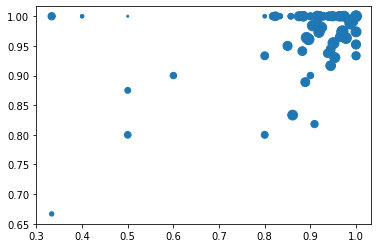

In [112]:
exps = explenations[-len(explenations)//2:]
real_precisions = [np.mean(dataset.labels_test[exp.fit_examples] == c.predict(dataset.test[exp.index].reshape(1, -1)))
                   for exp in exps]
test_precisions = [np.mean(c.predict(dataset.test[exp.fit_examples]) == c.predict(dataset.test[exp.index].reshape(1, -1))) 
                   for exp in exps]

plt.scatter(real_precisions, test_precisions, s = range(len(exps)))
plt.show()